This notebook just focuses on charting portfolio results from learned models.

### Import packages

In [1]:
import os
import glob
import zipfile
import shutil
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
import scipy.stats as stats
import datetime
import pylab as pl
import math
import codecs
import nltk
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import time
import json
import gensim
from gensim import corpora, models
from gensim.matutils import hellinger
from gensim.models.coherencemodel import CoherenceModel
import logging
%matplotlib inline

### Set all important file paths

In [2]:
pwd()

u'/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project'

In [3]:
# Richard path specs

# # At work:
# TEXT_PATH = "T:/Quant/TextAnalysis/Transcripts/SP100/Text/"
# PDF_PATH = "T:/Quant/TextAnalysis/Transcripts/SP100/PDF/"
# LIBRARY_PATH = "T:/Quant/TextAnalysis/Transcripts/SP100/Libraries/"

# # At home:
# dict_path = '/Users/Richard/Desktop/Berkeley/w266/'
# input_path = '/Users/Richard/Desktop/Berkeley/w266/repo/w266_project/'
# output_path = '/Users/Richard/Desktop/Berkeley/w266/'

# LIBRARY_PATH = '/Users/Richard/Desktop/Berkeley/w266/repo/w266_project/'



In [4]:
# Tom path specs

# Tom machine:
TEXT_DIR_LIST = ["T1", "T2", "T3", "T4"]
# PDF_PATH = "T:/Quant/TextAnalysis/Transcripts/SP100/PDF/"
LIBRARY_PATH = "/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/"

# On Tom's google cloud instance
# LIBRARY_PATH = "/home/seddon/w266_project/"



In [5]:
def get_filename_components(file_path, i):
    file_name_and_ext = os.path.basename(file_path)
    name_only = os.path.splitext(file_name_and_ext)[0]
    date, file_num, ticker = name_only.split("_")
    
#     file_path = file_path.split('_')
#     print (i, file_path)
#     date = file_path[0][-8:]
#     file_num = file_path[1]
#     ticker = file_path[2][:-4]
    return (ticker, date, file_num)
    

### Calculate Portfolio Returns

In [6]:
# process to read in returns into a dictionary: {month_end: {code: (return, market_cap)}}
def get_returns(myFilename):
    returns = {}
    with open(myFilename) as f:
        for line in f:
            code, date, rtn, mcap = line.rstrip('\n').rstrip('\r').split(',')
            if date != 'MthEnd':
                month_end = date[-4:] + date[3:5]
                if month_end not in returns.keys():
                    returns[month_end] = {}
                if rtn != 'NA':
                    rtn = float(rtn)/100
                if mcap != 'NA':
                    mcap = float(mcap)
                returns[month_end][code] = (rtn, mcap)
    return returns


def calculate_benchmark_returns(returns):
    benchmarks = {}
    for date, stocks in returns.items():
        ew_return_sum = 0
        mc_return_sum = 0
        num_stocks = 0
        total_cap = 0
        for code, stock_details in stocks.items():
            rtn, mcap = stock_details
            if rtn != 'NA':
                ew_return_sum += rtn
                num_stocks += 1
            if rtn != 'NA' and mcap != 'NA':
                mc_return_sum += rtn * mcap
                total_cap += mcap

            benchmarks[date] = (ew_return_sum / num_stocks, mc_return_sum / total_cap)

    return benchmarks


# This process converts scores from daily to month end
# It also considers if a score has been updated or not in the month.
# If NOT updated it retains the score from the previous month and increases its age or staleness by 1 month

def collate_month_end_scores(scores):

    # get all daily days - importantly in sorted chronological order oldest to newest
    dates = sorted(scores.keys())
    # get all month end dates from the daily dates
    m_list = sorted(list(set([date[:6] for date in dates])))

    # Note:  There can be months where we have no transcripts.  To make the
    # code later in the function work for that situation, we first identify
    # any missing months, then put in an empty scores dictionary for the
    # first day of that month.

    month_ends = []
    first = int(m_list[0])
    last = int(m_list[-1])
    first_yr = int(m_list[0][:4])
    last_yr = int(m_list[-1][:4])

    for y in range(first_yr, last_yr+1):
        for m in range(1, 13):
            if (y*100+m >= first and y*100+m <= last):
                month_ends.append("{:4d}{:02d}".format(y, m))

    # identify months where there are no transcripts
    missing_months = [m for m in month_ends if m not in m_list]
    for m in missing_months:
        scores[m+"01"] = {}
    # update date list to include any missing months added
    dates = sorted(scores.keys())

    # get all stocks in our coverage universe
    codes = []
    for date in dates:
        for code in scores[date].keys():
            if code not in codes:
                codes.append(code)
    # set the current month end to None to start the process
    curr_month_end = None
    # create an empty list to house the month end scores
    monthly_scores = {}

    # pass through the scores in chronological order
    for date in dates:

        # collect the month end for the current date
        month_end = date[:6]

        # if found a new month end
        if month_end != curr_month_end:

            # add a new month end dictionary for the monthly scores dictionary
            monthly_scores[month_end] = {}

            # check if there is a past month
            # if no past month populate the empty dictionary for scores on the given date, i.e. first entry
            if len(monthly_scores.keys()) < 2:
                for code, score in scores[date].items():
                    monthly_scores[month_end][code] = (score, 1) # note including a score age parameter

            # otherwise if a past month exists add missing codes for the month either as NA or the previous month value
            else:

                # check if there is a previous month to grab scores from
                prev_month_end_idx = month_ends.index(curr_month_end) - 1

                # there is a previous month
                if prev_month_end_idx >= 0:
                    # collect previous month end
                    prev_month_end = month_ends[prev_month_end_idx]
                    # iterate through codes to find ones not in the current month end dictionary
                    for code in codes:
                        if code not in monthly_scores[curr_month_end].keys():
                            if code in monthly_scores[prev_month_end].keys():
                                # there is no previous score
                                if monthly_scores[prev_month_end][code][0] == 'NA':
                                    monthly_scores[curr_month_end][code] = ('NA', 0)
                                # there is a previous score
                                else:
                                    # get the previous score and increment age by one month
                                    (prev_score, age) = monthly_scores[prev_month_end][code]
                                    monthly_scores[curr_month_end][code] = (prev_score, age + 1)

                # there is not a previous month
                else:
                    # populate missing codes as 'NA'
                    for code in codes:
                        if code not in monthly_scores[curr_month_end].keys():
                            monthly_scores[curr_month_end][code] = ('NA', 0)

            # update the current month end parameter
            curr_month_end = month_end

        # haven't found a new month
        else:
            for code, score in scores[date].items():
                monthly_scores[month_end][code] = (score, 1) # note including a score age parameter

    return monthly_scores


# process to calculate the percentile of each of the scores subject to a maximum age of the score
def get_percentile_scores(scores, max_age):
    percentiles = []
    numeric_scores = [score for (score, age) in scores.values() if score != 'NA' and age <= max_age]
    for code in sorted(scores.keys()):
        score, age = scores[code]
        if score == 'NA' or age > max_age:
            percentiles.append('NA')
        else:
            percentiles.append(stats.percentileofscore(numeric_scores, score))
    return percentiles

def convert_to_portfolio_int(percentile, num_portfolios):
    num = num_portfolios * percentile / 100
    if num < 0:
        return 0
    elif num >= num_portfolios:
        return num_portfolios - 1
    else:
        return int(num)

def create_fractile_portfolios(scores, num_portfolios, max_age):
    percentiles = get_percentile_scores(scores, max_age)
    # populate holdings dictionary for selected number of portfolios
    holdings = {i:[] for i in range(0,num_portfolios)}
    holdings['NA'] = []
    for code, percentile in zip(sorted(scores.keys()), percentiles):
        if percentile == 'NA':
            holdings['NA'].append(code)
        else:
            port_num = convert_to_portfolio_int(percentile, num_portfolios)
            holdings[port_num].append(code)
    return holdings


def average_return(returns, benchmark):
    if len(returns) == 0:
        average_alpha = 0
    else:
        average_alpha = sum(returns)/len(returns) - benchmark
    return (average_alpha, len(returns))

def calculate_portfolio_returns(portfolios, returns, benchmark, bm_type=0):
    portfolio_returns = {portfolio:[] for portfolio in portfolios.keys()}
    for portfolio, stocks in portfolios.items():
        if portfolio != 'NA':
            for stock in stocks:
                if stock in returns.keys():
                    if returns[stock][0] != 'NA':
                        portfolio_returns[portfolio].append(returns[stock][0])
        else:
            for stock in stocks:
                portfolio_returns['NA'].append(benchmark[bm_type])

    portfolio_returns = {pf:average_return(rets, benchmark[bm_type]) for pf, rets in portfolio_returns.items()}

    return portfolio_returns


# This process produces a time series of monthly portfolio returns by iterating through the whole scores dictionary
def portfolio_return_time_series(scores, returns, benchmarks, num_portfolios, max_age=4):
    monthly_portfolios = {}
    portfolio_return_time_series = {}

    # get key dates
    dates = sorted(scores.keys())                                 # important in chronological order
    month_ends = sorted(list(set([date[:6] for date in dates])))  # important in chronological order

    for month_end in month_ends[1:-1]:
        monthly_portfolios[month_end] = create_fractile_portfolios(scores[month_end], num_portfolios, max_age)
        portfolio_return_time_series[month_end] = calculate_portfolio_returns(monthly_portfolios[month_end], returns[month_end], benchmarks[month_end])
    return portfolio_return_time_series


def calculate_cumulative_alpha(time_series, dates):
    port_nums = [num for num in time_series[list(time_series.keys())[0]].keys() if num != 'NA']
    cumulative_portfolios = {i:[] for i in port_nums}
    cumulative_alphas = []
    for date in dates:
        return_series = time_series[date]
        for port_num in port_nums:
            cumulative_portfolios[port_num].append(return_series[port_num][0])
    for portfolio in sorted(cumulative_portfolios.keys()):
        cumulative_alphas.append([sum(cumulative_portfolios[portfolio][:i]) for i in range(len(cumulative_portfolios[portfolio]))])
    return cumulative_alphas


def calculate_portfolio_holding_numbers(time_series, dates):
    port_nums = [num for num in time_series[list(time_series.keys())[0]].keys() if num != 'NA']
    portfolio_holdings = {i:[] for i in port_nums}
    holdings = []
    for date in dates:
        return_series = time_series[date]
        for port_num in port_nums:
            portfolio_holdings[port_num].append(return_series[port_num][1])
    for portfolio in sorted(portfolio_holdings.keys()):
        holdings.append(portfolio_holdings[portfolio])
    return holdings


def convert_YYYYMM(date):
    year = int(date[:4])
    month = int(date[4:])
    day = 1
    return datetime.datetime(year=year, month=month, day=day)

def print_time_series(time_series, dates):
    dates = [convert_YYYYMM(date) for date in dates]
    for i in range(len(time_series)):
        series = time_series[i]
        series_label = 'P' + str(i+1)
        if i == 0:
            pl.plot(dates, series, label=series_label, color='black')
        else:
            pl.plot(dates, series, label=series_label)
    pl.legend(loc=0)
    pl.show()


def produce_portfolio_results(scores, LIBRARY_PATH, num_portfolios, max_age=4):

    # Get returns
    returns = get_returns(LIBRARY_PATH + 'returns_data.csv')

    # Calculate the benchmark returns
    benchmarks = calculate_benchmark_returns(returns)

    # Collate the month end scores from the daily score data
    monthly_scores = collate_month_end_scores(scores)
    
    # Get all daily dates from score and convert to month ends
    dates = sorted(scores.keys())                                 # important in chronological order
    month_ends = sorted(list(set([date[:6] for date in dates])))  # important in chronological order

    # Create month end portfolios
    monthly_portfolios = {}
    for month_end in month_ends:
        monthly_portfolios[month_end] = create_fractile_portfolios(monthly_scores[month_end], num_portfolios, max_age)

    # Calculate monthly returns time series
    monthly_returns_time_series = portfolio_return_time_series(monthly_scores, returns, benchmarks, num_portfolios)

    # Calculate cumulative alpha and portfolio holding numbers time series
    month_ends = sorted(returns.keys())                           # important in chronological order
    cumulative_alphas = calculate_cumulative_alpha(monthly_returns_time_series, month_ends)
    holdings = calculate_portfolio_holding_numbers(monthly_returns_time_series, month_ends)

    # Print cumulative alpha and portfolio holding numbers
    print_time_series(cumulative_alphas, month_ends)
    print_time_series(holdings, month_ends)
    
    return collate_month_end_scores(scores)
    

def convert_monthly_scores_to_changes(monthly_scores):

    m_scores_dates = sorted(monthly_scores.keys())

    # get all stocks in our coverage universe
    codes = []
    for date in m_scores_dates:
        for code in monthly_scores[date].keys():
            if code not in codes:
                codes.append(code)

    # Create an empty dict for the changes of scores
    changes = {date: {} for date in m_scores_dates[2:]}

    # Add changes for the third month in the data series as ('NA',0)
    for ticker in codes:
        changes[m_scores_dates[2]][ticker] = ('NA',0)

    # Iterate through the dates
    for i in range(3,len(m_scores_dates)):

        #  Get current date and previous date
        curr_date = m_scores_dates[i]
        prev_date = m_scores_dates[i-1]

        for ticker in monthly_scores[curr_date]:

            # get score information
            curr_score, curr_score_age = monthly_scores[curr_date][ticker]
            prev_score, prev_score_age = monthly_scores[prev_date][ticker]
            prev_change, prev_change_age = changes[prev_date][ticker]

            if curr_score == 'NA': # still no absolute score found

                changes[curr_date][ticker] = ('NA',0)

            else:

                # A change has not been found and still has not
                if prev_change == 'NA' and (prev_score == 'NA' or curr_score == prev_score): 
                    changes[curr_date][ticker] = ('NA',0)         

                # A change has not been found, but has now
                elif prev_change == 'NA' and curr_score != prev_score:
                    changes[curr_date][ticker] = (curr_score-prev_score,1)         

                # A change has not been found, but no further update this month
                elif prev_change != 'NA' and curr_score == prev_score: 
                    changes[curr_date][ticker] = (prev_change, prev_change_age + 1)

                # A change has been found and there is an update this month
                elif prev_change != 'NA' and curr_score != prev_score: 
                    changes[curr_date][ticker] = (curr_score - prev_score, 1)
 
    return changes


def produce_portfolio_changes_results(changes, LIBRARY_PATH, num_portfolios, max_age=4):

    # Get returns
    returns = get_returns(LIBRARY_PATH + 'returns_data.csv')

    # Calculate the benchmark returns
    benchmarks = calculate_benchmark_returns(returns)

    month_ends = sorted(changes.keys())  # important in chronological order

    # Create month end portfolios
    monthly_portfolios = {}
    for month_end in month_ends:
        monthly_portfolios[month_end] = create_fractile_portfolios(changes[month_end], num_portfolios, max_age)

    # Calculate monthly returns time series
    monthly_returns_time_series = portfolio_return_time_series(changes, returns, benchmarks, num_portfolios)

    # Calculate cumulative alpha and portfolio holding numbers time series
    month_ends = sorted(returns.keys())[6:]                           # important in chronological order
    cumulative_alphas = calculate_cumulative_alpha(monthly_returns_time_series, month_ends)
    holdings = calculate_portfolio_holding_numbers(monthly_returns_time_series, month_ends)

    # Print cumulative alpha and portfolio holding numbers
    print_time_series(cumulative_alphas, month_ends)
    print_time_series(holdings, month_ends)
    

## Produce portfolio results for a number of models

In [7]:
def get_topic_sims_results(model_dir):
    
    topic_sims_results = {}
    
    with open(LIBRARY_PATH+"saved_models/"+model_dir+"/hell_sims.txt") as f:
        hellinger_sims = json.loads(f.read())    
    
    for file_id in hellinger_sims:
        ticker, date = file_id.split('_')

        if date not in topic_sims_results.keys():
            topic_sims_results[date] = {}

        avg_sim = np.mean([hellinger_sims[file_id][q_num] for q_num in hellinger_sims[file_id]])

        topic_sims_results[date][ticker] = avg_sim
        
    return topic_sims_results

top20_len20_prebase_df5



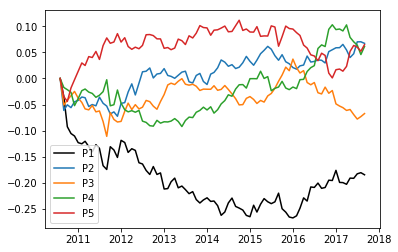

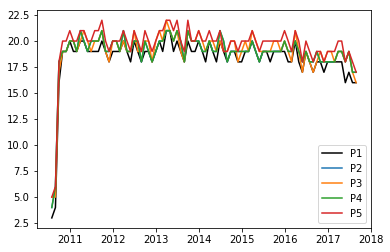

top20_len20_prebase_df10



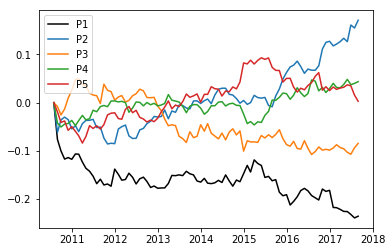

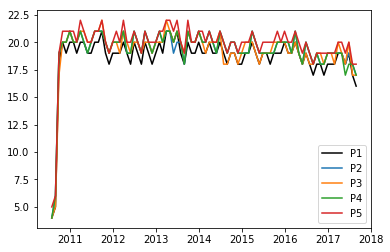

top20_len20_prebase_df20



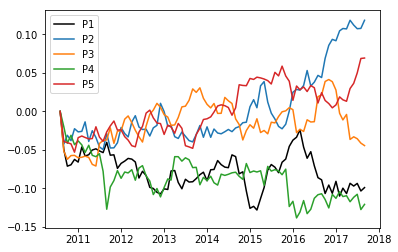

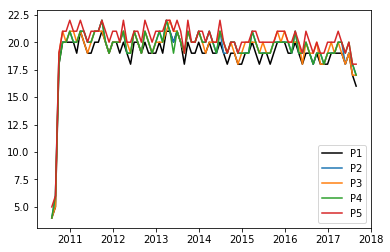

In [8]:
model_dir_list = ["top20_len20_prebase_df5", "top20_len20_prebase_df10",
                  "top20_len20_prebase_df20"]

for model_dir in model_dir_list:
    
    print model_dir
    print
    topic_sims_results = get_topic_sims_results(model_dir)
    
    produce_portfolio_results(topic_sims_results, LIBRARY_PATH, num_portfolios=5, max_age=4)

top10_len10_prebase_ps20_it100



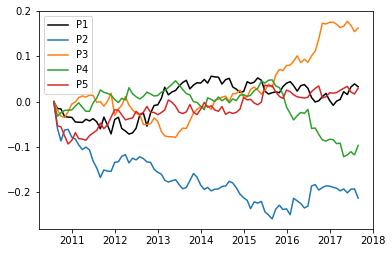

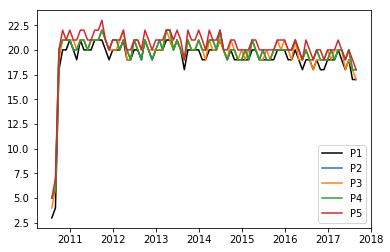

top10_len20_prebase_ps20_it100



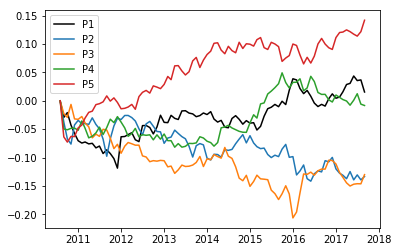

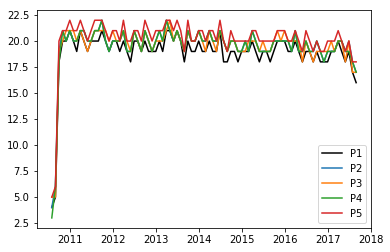

top10_len40_prebase_ps20_it100



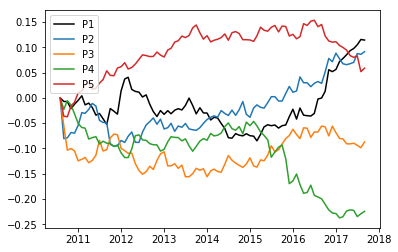

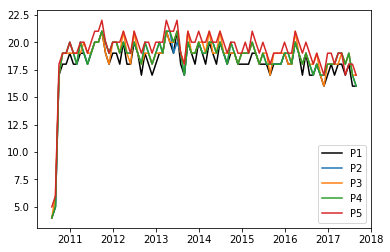

top20_len10_prebase_ps20_it100



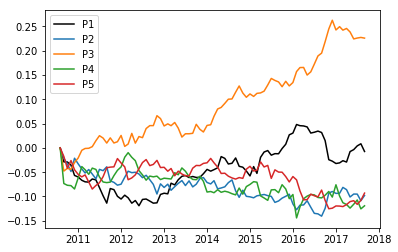

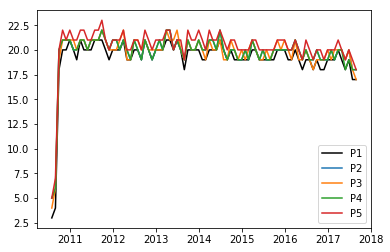

top20_len20_prebase_ps20_it100



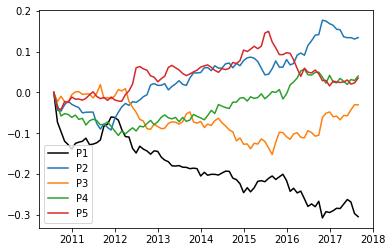

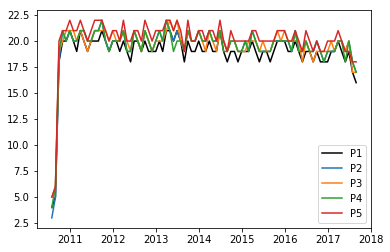

top20_len40_prebase_ps20_it100



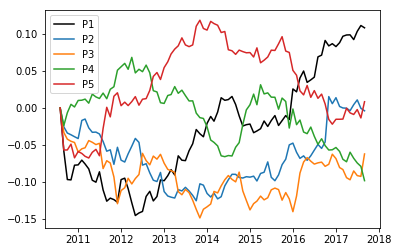

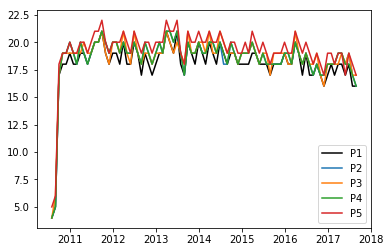

top40_len10_prebase_ps20_it100



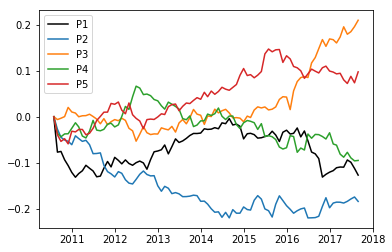

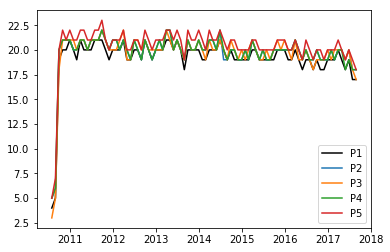

top40_len20_prebase_ps20_it100



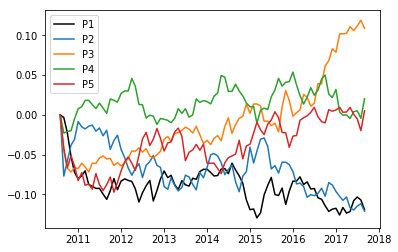

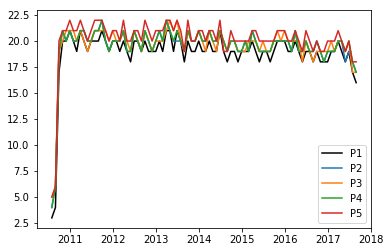

top40_len40_prebase_ps20_it100



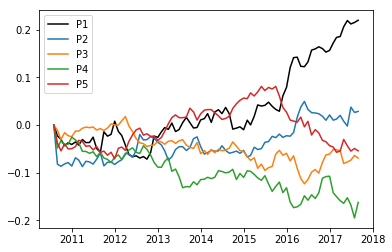

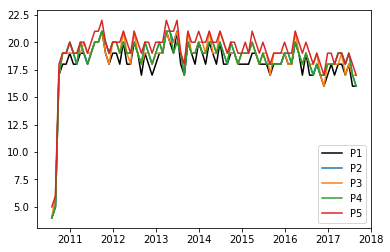

In [9]:
model_dir_list = ["top10_len10_prebase_ps20_it100", "top10_len20_prebase_ps20_it100",
                  "top10_len40_prebase_ps20_it100", "top20_len10_prebase_ps20_it100",
                  "top20_len20_prebase_ps20_it100", "top20_len40_prebase_ps20_it100",
                  "top40_len10_prebase_ps20_it100", "top40_len20_prebase_ps20_it100",
                  "top40_len40_prebase_ps20_it100"]

for model_dir in model_dir_list:
    
    print model_dir
    print
    topic_sims_results = get_topic_sims_results(model_dir)
    
    produce_portfolio_results(topic_sims_results, LIBRARY_PATH, num_portfolios=5, max_age=4)

1216_top30_len30_prebase



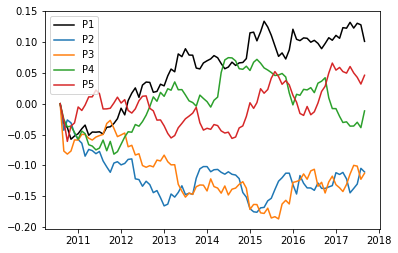

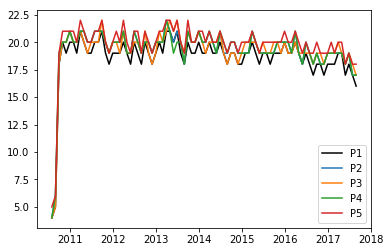

1216_top30_len40_prebase



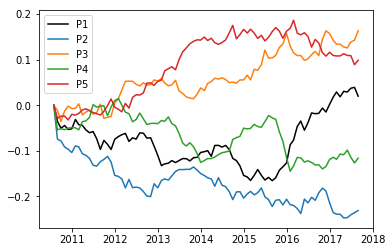

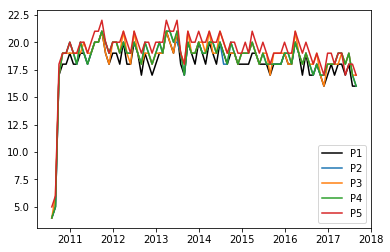

1216_top30_len50_prebase



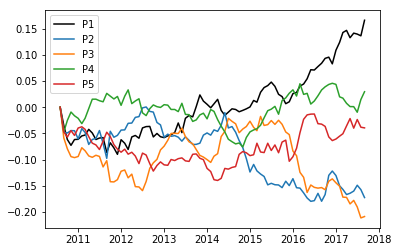

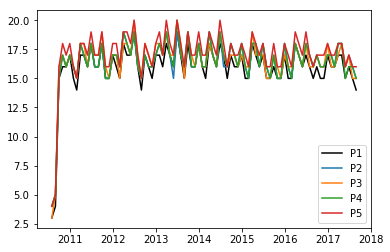

1216_top40_len30_prebase



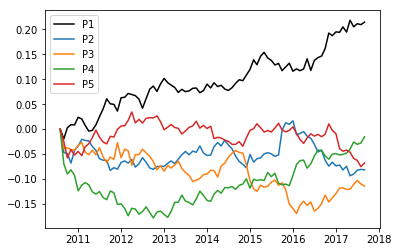

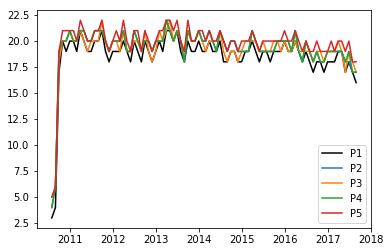

1216_top40_len40_prebase



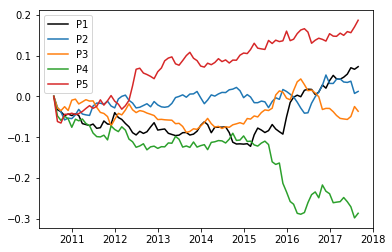

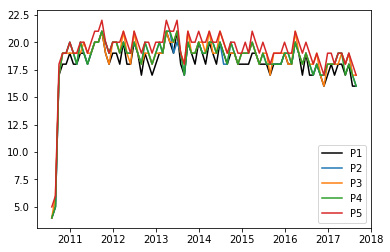

1216_top40_len50_prebase



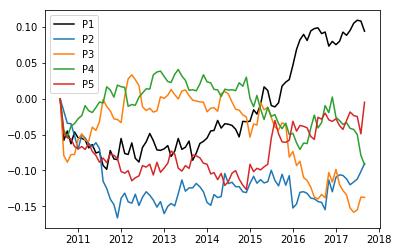

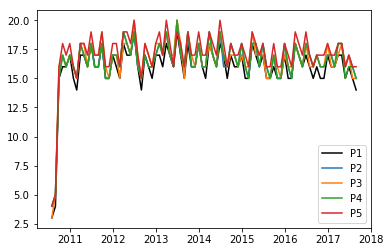

1216_top50_len30_prebase



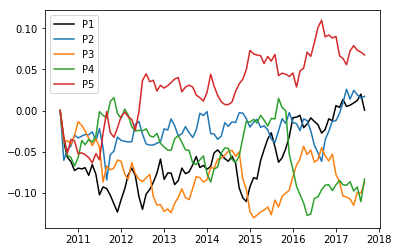

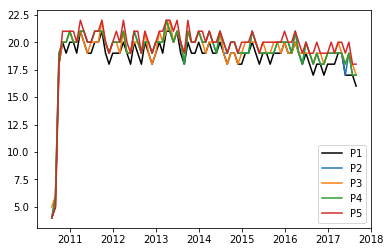

1216_top50_len40_prebase



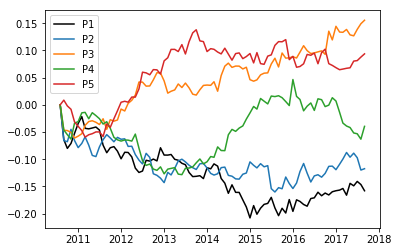

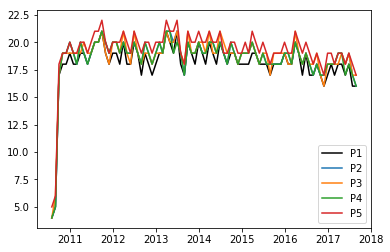

1216_top50_len50_prebase



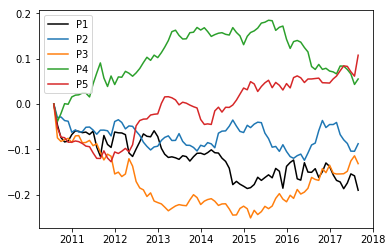

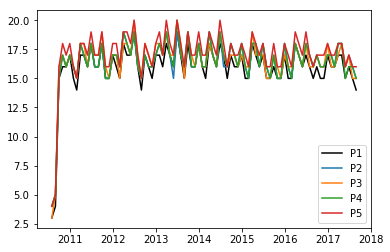

In [10]:
model_dir_list = ["1216_top30_len30_prebase", "1216_top30_len40_prebase","1216_top30_len50_prebase",
                  "1216_top40_len30_prebase", "1216_top40_len40_prebase","1216_top40_len50_prebase",
                  "1216_top50_len30_prebase", "1216_top50_len40_prebase","1216_top50_len50_prebase",
                    ]

for model_dir in model_dir_list:
    
    print model_dir
    print
    topic_sims_results = get_topic_sims_results(model_dir)
    
    produce_portfolio_results(topic_sims_results, LIBRARY_PATH, num_portfolios=5, max_age=4)

Check_top40_len40_prebase



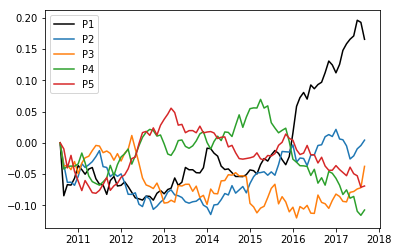

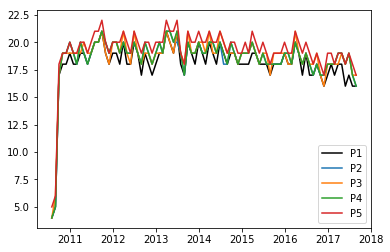

In [11]:
model_dir_list = ["Check_top40_len40_prebase"]

for model_dir in model_dir_list:
    
    print model_dir
    print
    topic_sims_results = get_topic_sims_results(model_dir)
    
    produce_portfolio_results(topic_sims_results, LIBRARY_PATH, num_portfolios=5, max_age=4)

top40_len40_prebase_df5



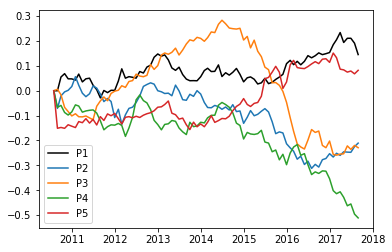

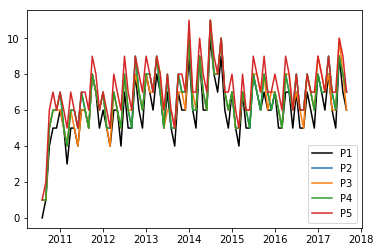

top40_len40_prebase_df10



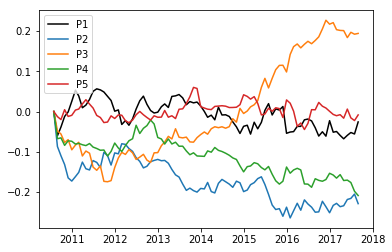

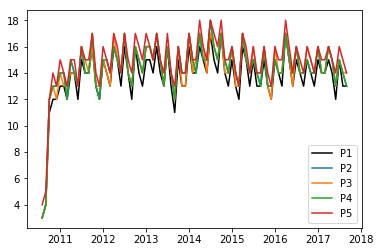

top40_len40_prebase_df20



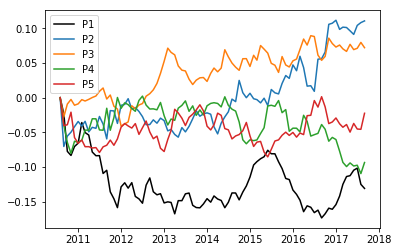

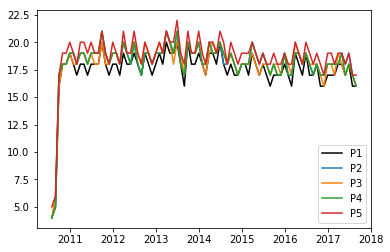

In [12]:
model_dir_list = ["top40_len40_prebase_df5", "top40_len40_prebase_df10", 
                  "top40_len40_prebase_df20"]

for model_dir in model_dir_list:
    
    print model_dir
    print
    topic_sims_results = get_topic_sims_results(model_dir)
    
    produce_portfolio_results(topic_sims_results, LIBRARY_PATH, num_portfolios=5, max_age=4)